一般的に待機児童問題と呼ばれる問題がある。実際の待機児童のデータの様子の可視化を試みる。

In [1]:
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import re
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
import matplotlib
jafont=matplotlib.font_manager.FontProperties(fname="ipaexg.ttf")
ja = dict(fontproperties=jafont)

幼稚園と保育園を弾力的に運用できるようにするために「こども園」という仕組みが導入された。この新制度の運用状況は[神戸市のページ](http://www.city.kobe.lg.jp/child/grow/shinseido/index02_03.html)でデータが公開されている。「待機児童問題」でイメージされる状況と、「申込児童数」の意味するところは必ずしも一致しない。申込児童数には「今現在（定員などの都合でやむをえず）遠くに通うことになっているけれども、本当は近くのところに通いたい」というのも含まれるだろう。とはいえ、おおよその現象は申込児童数に現れているものとみなしてよいだろう。

幼稚園・保育園・こども園のデータを統合して `geojson` の形式にできるようにしたので、それを使う。読み込むデータはとりあえず最新版の 2016-09-15 時点のものを使ってみた。

In [3]:
nib_ = gpd.read_file("../data/hkwi/shinseido-2016-09.json")
# そのまま集計すると、分園の数だけ二重に集計してしまう
nib = nib_[nib_["状況,参照"]!="本園"]

# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]

nib_ = nib[k1+k2].applymap(drop_notes)
nib = nib.assign(**{k:nib_[k] for k in k1+k2})

## 神戸市全域

まずは市全域を合算してプロットしてみる。0歳児から5歳児に向かって、単調に減少する形をしていることが読み取れる。

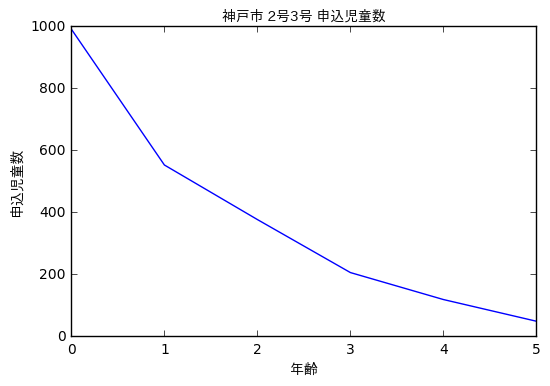

In [4]:
_ = plt.plot(nib.sum()[k2].values)
_ = plt.title("神戸市 2号3号 申込児童数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("申込児童数", **ja)

参考までに年齢ごとの人口をプロットしてみる。人口のデータは神戸市の[年齢別の人口データ](http://www.city.kobe.lg.jp/information/data/statistics/toukei/jinkou/juukijinkou.html)（オープンデータ）を使う。2016-09-15 時点のデータは存在しないので、2016-08 末時点のデータで代用する。

In [5]:
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))

zib = load_zensi("../data/kobe/zensi2808.xls")

プロットする。0歳のほうが少ない。

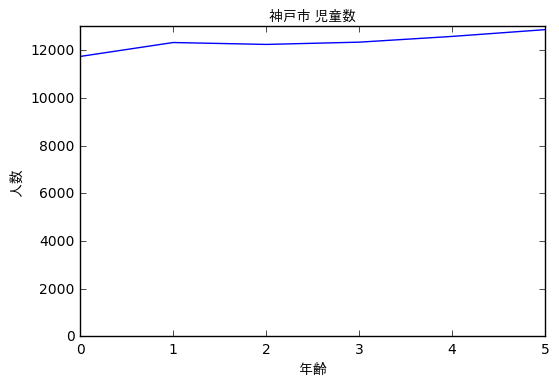

In [6]:
_ = plt.plot(zib.sum()[k3].T.values)
_ = plt.ylim(ymin=0)
_ = plt.title("神戸市 児童数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("人数", **ja)

単位児童あたりの申込数をプロットする。やっぱり0歳から5歳に向かって減っていく傾向にある。

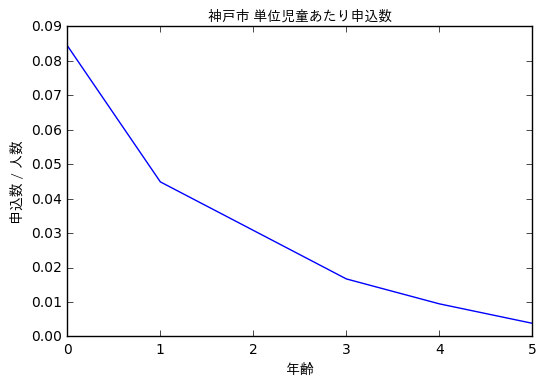

In [7]:
r0 = nib.sum().rename(index=dict(zip(k2,k3)))/zib.sum()
_ = plt.plot(r0[k3].T.values)
_ = plt.title("神戸市 単位児童あたり申込数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("申込数 / 人数", **ja)

## 地区レベル

地区ごとに集計してプロットしてみる。大まかに全体としても 0 歳から 5 歳に向かって減る形をしている。

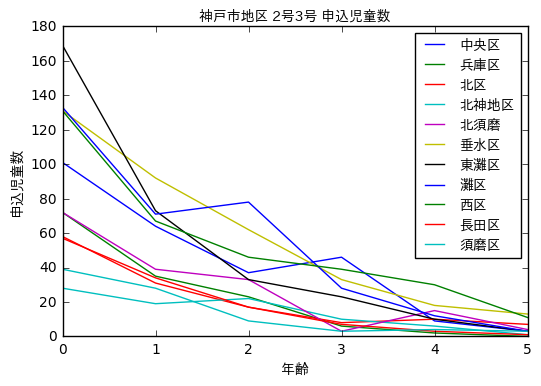

In [8]:
d0 = nib.groupby("状況,地区").sum()
_ = plt.plot(d0[k2].T.values)
_ = plt.title("神戸市地区 2号3号 申込児童数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("申込児童数", **ja)
_ = plt.legend(d0.index, prop=jafont)

地区レベルでの児童数はこのようになっている。

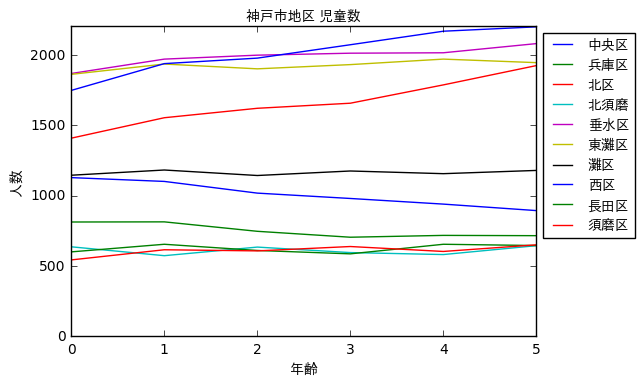

In [9]:
d1 = zib.groupby("区・支所").sum().rename(index={"北須磨支所":"北須磨"})
_ = plt.plot(d1[k3].T.values)
_ = plt.ylim(ymin=0)
_ = plt.title("神戸市地区 児童数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("人数", **ja)
_ = plt.legend(d1.index, prop=jafont, bbox_to_anchor=(1, 1), loc=2)

単位児童当たりの申込数をプロットする。人口データと申込児童数データの地域区分を揃えてから計算する。

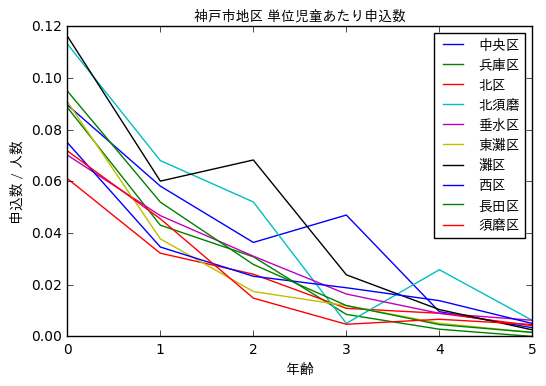

In [10]:
nib2 = nib.groupby("状況,地区").sum()
nib2.loc["北区",:] += nib2.loc["北神地区",:]
nib3 = nib2.loc[[i for i in nib2.index if i!="北神地区"],:].rename(columns=dict(zip(k2,k3)))
d2 = (nib3/d1)[k3]
_ = plt.plot(d2.T.values)
_ = plt.title("神戸市地区 単位児童あたり申込数", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("申込数 / 人数", **ja)
_ = plt.legend(d2.index, prop=jafont)

## 倍率

地区ごとに全体と比べて、どのぐらい倍率が違うのかを表示する。倍率で見ると、0 歳のほうが地域ごとのばらつきは小さく、地域ごと年齢ごとの状況は年齢が上がるほうが大きくなる。

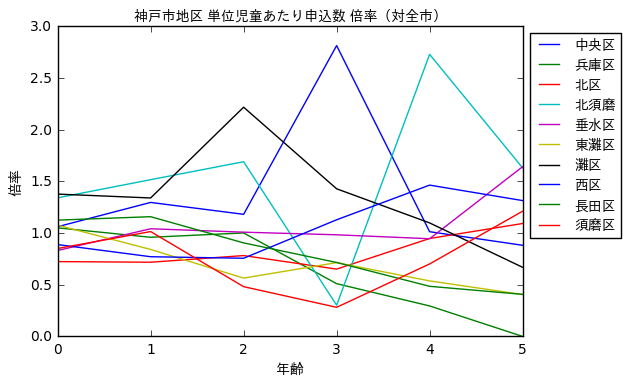

In [11]:
r1 = d2/r0
_ = plt.plot(r1[k3].T.values)
_ = plt.title("神戸市地区 単位児童あたり申込数 倍率（対全市）", **ja)
_ = plt.xlabel("年齢", **ja)
_ = plt.ylabel("倍率", **ja)
_ = plt.legend(r1.index, prop=jafont, loc=2, bbox_to_anchor=(1.0, 1.0))